In [10]:
%matplotlib inline
import sys, os
sys.path.append('../../')
import h5py
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from decimal import Decimal
#from tools import OHLC, Density
#from tools import open_file, products
from tools.instruments import instruments
from IPython.display import clear_output
import time
import math

In [2]:
%load_ext autoreload
%aimport tools.TDOP
%autoreload 2

### 환경 설정

In [12]:
Tau = 50 #time constant

In [15]:
filepath = os.path.join(os.getcwd(), '..','..','data','price density',f'density_Tau_{Tau}.hdf')
#file = h5py.File(filepath, 'w')

In [16]:
db_symbols = instruments.quotes().columns.levels[0].tolist()
tradables = instruments.filter(tradable=True)
products = [ins for ins in tradables if ins.symbol in db_symbols]

for cnt, ins in enumerate(products):
    print(f"{ins.symbol} ({cnt+1}/{len(products)})")
    file = h5py.File(filepath, 'a')
    #ins = instruments['MP']
    quotes = ins.quotes()[['high','low','volume']].dropna()
    #최고가 = 최저가인 경우 이상하다고 판단하여 거래량을 0으로 만듬
    quotes.loc[quotes[quotes['high']==quotes['low']].index, 'volume']=0
    ticks = (quotes['high']-quotes['low'])/ins.tickunit + 1
    quotes['density'] = quotes['volume']/ticks

    m = quotes['low'].min() - ins.tickunit*100
    M = quotes['high'].max() + ins.tickunit*100
    priceindex = np.array([i.round(ins.decimal_places) for i in np.arange(m,M,ins.tickunit)])

    S = np.full((len(priceindex),), 0)
    tol  = ins.tickunit/3 #float 처리용 tolerance
    densities = []
    last_date = quotes.index[0] - pd.Timedelta(days=1)
    for date, quote in quotes.iterrows():
        dt = (date-last_date).days
        lower = quote['low'] - tol
        upper = quote['high'] + tol
        X = np.where( (lower < priceindex) & (priceindex < upper), quote['density'], 0)
        S = S + (1-pow(math.e, -dt/Tau))*(X-S) #exponential lag
        densities.append(S)
        last_date = date
    densities = np.array(densities)


    group = file.create_group(ins.symbol)
    dates = quotes.index.values
    group.create_dataset("dates", dates.shape, data=dates.astype('int64'))
    group.create_dataset("priceindex", priceindex.shape, data=priceindex)
    group.create_dataset("density", densities.shape, data=densities, compression="gzip")
    file.flush()
    file.close()

AD (1/39)
BO (2/39)
BP (3/39)
C (4/39)
CC (5/39)
CD (6/39)
CL (7/39)
CT (8/39)
DX (9/39)
EC (10/39)
ES (11/39)
FV (12/39)
GC (13/39)
HG (14/39)
HO (15/39)
JY (16/39)
KC (17/39)
LC (18/39)
LN (19/39)
MD (20/39)
NE (21/39)
NG (22/39)
NK (23/39)
NQ (24/39)
O (25/39)
OJ (26/39)
PA (27/39)
PL (28/39)
RB (29/39)
RTY (30/39)
S (31/39)
SB (32/39)
SF (33/39)
SI (34/39)
SM (35/39)
TU (36/39)
TY (37/39)
US (38/39)
W (39/39)


In [170]:
file.close()

### Verification

In [17]:
file = h5py.File(filepath, 'r')
symbol = 'W'
TD = file[symbol]

In [18]:
ad = instruments[symbol]
priceindex = TD['priceindex'][:]
dates = TD['dates'][:].astype('M8[ns]')
densities = TD['density']
quotes = ad.quotes()

In [19]:
densities.shape

(15773, 7468)

In [20]:
dates.shape

(15773,)

In [21]:
priceindex.shape

(7468,)

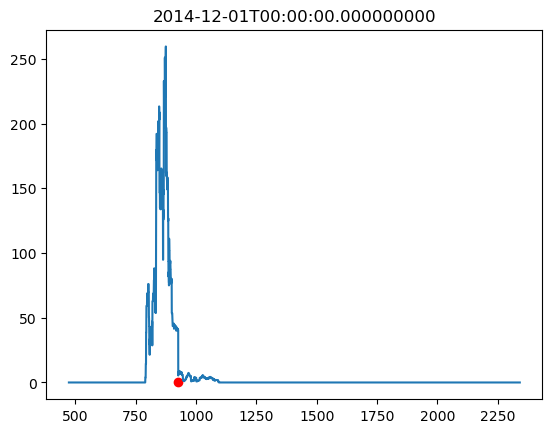

KeyboardInterrupt: 

In [22]:
for i, date in enumerate(dates):
    if i< 13880:
        continue
    plt.title(date)
    plt.scatter(quotes.loc[date].close  ,0,color='red')
    plt.plot(priceindex, densities[i])
    plt.show()
    time.sleep(0.1)
    clear_output(wait=True)

In [9]:
pow(math.e, -0.01)

0.9900498337491681